<a href="https://colab.research.google.com/github/emraankazmi5-coder/deeplearning/blob/main/presentation_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTS**

In [18]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)

100%|██████████| 787M/787M [00:09<00:00, 88.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1


**CONFIGURATION**

In [44]:
IMG_SIZE    = 64
CHANNELS    = 3
LATENT_DIM  = 128
BATCH_SIZE  = 32
EPOCHS      = 50
LR          = 1e-3
DATASET_DIR = "/root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages" # Corrected path based on os.listdir
SEED        = 42

# ── Sampling config ─────────────────────────────────────────
N_CATS = 500     # 500 random cat images
N_DOGS = 500     # 500 random dog images
TOTAL  = N_CATS + N_DOGS   # = 1000 total images

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

**LOAD 500 CATS + 500 DOGS RANDOMLY**

In [45]:
def load_random_images(dataset_dir, n_cats=500, n_dogs=500,
                       img_size=IMG_SIZE):
    """
    Load exactly n_cats random cat images and
    n_dogs random dog images.

    Total = 1000 images (500 cats + 500 dogs)

    Steps:
      1. List all files in Cat/ and Dog/ folders
      2. Randomly pick 500 from each
      3. Resize to 64x64
      4. Normalize to [0, 1]
    """
    images, labels = [], []
    class_config = {
        "Cat": (0, n_cats),    # label=0, pick 500
        "Dog": (1, n_dogs),    # label=1, pick 500
    }

    for class_name, (label, n_pick) in class_config.items():
        class_dir = os.path.join(dataset_dir, class_name)

        # Get all available files
        all_files = os.listdir(class_dir)

        # ── Randomly select n_pick files ────────────────────
        selected_files = random.sample(all_files, min(n_pick, len(all_files)))

        print(f"Loading {n_pick} random {class_name} images "
              f"from {len(all_files)} available...")

        loaded = 0
        for fname in selected_files:
            fpath = os.path.join(class_dir, fname)
            try:
                img = Image.open(fpath).convert("RGB")
                img = img.resize((img_size, img_size), Image.LANCZOS)
                arr = np.array(img, dtype=np.float32) / 255.0
                images.append(arr)
                labels.append(label)
                loaded += 1
            except Exception:
                continue   # skip corrupted files

        print(f"  ✔ Successfully loaded: {loaded} {class_name} images")

    images = np.array(images)
    labels = np.array(labels)

    # Shuffle so cats and dogs are mixed
    idx    = np.random.permutation(len(images))
    images = images[idx]
    labels = labels[idx]

    return images, labels


print("=" * 55)
print("  Loading 500 Cats + 500 Dogs = 1000 Total Images")
print("=" * 55)

images, labels = load_random_images(
    DATASET_DIR,
    n_cats=N_CATS,
    n_dogs=N_DOGS
)

# ── Verify counts ────────────────────────────────────────────
print(f"\nTotal images loaded : {len(images)}")
print(f"  Cat images (0)    : {(labels == 0).sum()}")   # 500
print(f"  Dog images (1)    : {(labels == 1).sum()}")   # 500
print(f"Image shape         : {images[0].shape}")       # (64, 64, 3)
print(f"Pixel range         : [{images.min():.1f}, {images.max():.1f}]")

  Loading 500 Cats + 500 Dogs = 1000 Total Images
Loading 500 random Cat images from 12491 available...
  ✔ Successfully loaded: 500 Cat images
Loading 500 random Dog images from 12470 available...
  ✔ Successfully loaded: 500 Dog images

Total images loaded : 1000
  Cat images (0)    : 500
  Dog images (1)    : 500
Image shape         : (64, 64, 3)
Pixel range         : [0.0, 1.0]


In [43]:
import os
print(os.listdir(DATASET_DIR))

['PetImages', 'readme[1].txt', 'MSR-LA - 3467.docx']


In [40]:
import os
print(os.listdir(path))

['kagglecatsanddogs_3367a']


**STEP 2 — TRAIN / VALIDATION SPLIT (80% / 20%)**


In [46]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels,
    test_size=0.2,
    random_state=SEED,
    stratify=labels
)

print(f"\nTrain : {X_train.shape[0]} images  "
      f"(Cats={( y_train==0).sum()}, Dogs={(y_train==1).sum()})")
print(f"Val   : {X_val.shape[0]} images  "
      f"(Cats={(y_val==0).sum()}, Dogs={(y_val==1).sum()})")


Train : 800 images  (Cats=400, Dogs=400)
Val   : 200 images  (Cats=100, Dogs=100)


**STEP 3 — VISUALIZE THE 1000 SAMPLE**

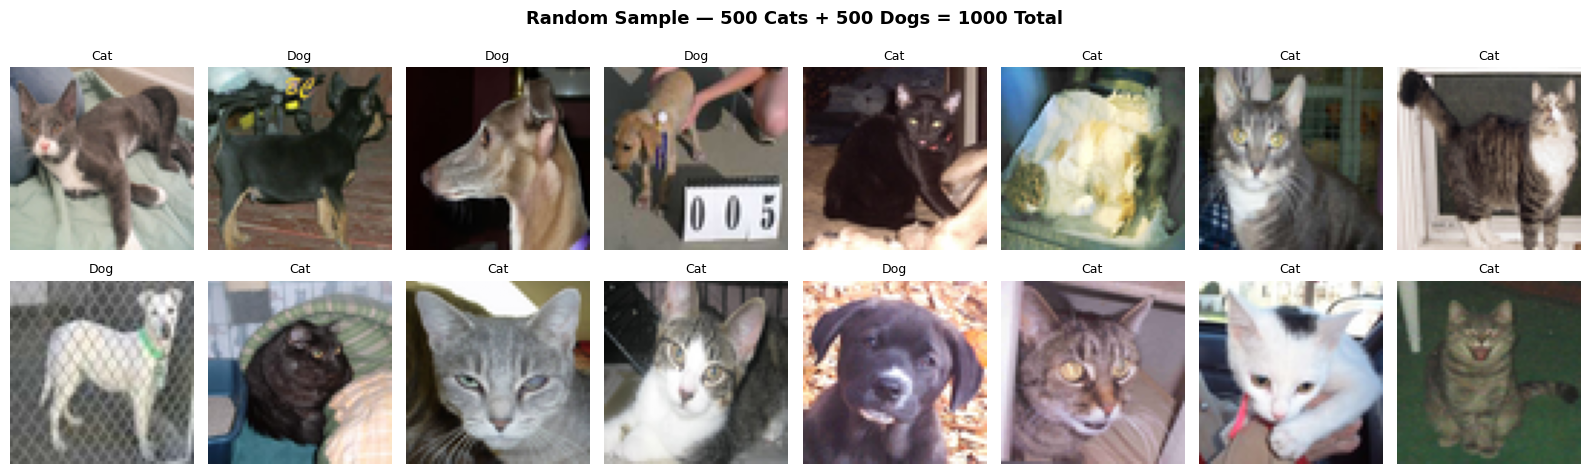

Saved: sample_grid.png


In [47]:
def show_sample_grid(images, labels, n=16, save_path="sample_grid.png"):
    """Show a grid of randomly selected images from our 1000 sample."""
    idx       = np.random.choice(len(images), n, replace=False)
    label_map = {0: "Cat", 1: "Dog"}

    fig, axes = plt.subplots(2, n // 2, figsize=(n, 5))
    fig.suptitle(f"Random Sample — 500 Cats + 500 Dogs = {TOTAL} Total",
                 fontsize=13, fontweight="bold")

    for i, ax in enumerate(axes.flat):
        ax.imshow(np.clip(images[idx[i]], 0, 1))
        ax.set_title(label_map[labels[idx[i]]], fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Saved: {save_path}")

show_sample_grid(images, labels)

**STEP 4  BUILD AUTOENCODER**

In [48]:
def build_encoder(input_shape, latent_dim):
    inputs = keras.Input(shape=input_shape, name="encoder_input")

    # Conv Block 1
    x = layers.Conv2D(32, (3, 3), activation="relu",
                      padding="same", name="enc_conv1")(inputs)
    x = layers.MaxPooling2D((2, 2), name="enc_pool1")(x)    # 64→32

    # Conv Block 2
    x = layers.Conv2D(64, (3, 3), activation="relu",
                      padding="same", name="enc_conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="enc_pool2")(x)    # 32→16

    # Bottleneck
    x      = layers.Flatten(name="enc_flatten")(x)
    latent = layers.Dense(latent_dim, activation="relu",
                          name="bottleneck")(x)              # → 128

    return Model(inputs, latent, name="Encoder")


def build_decoder(latent_dim, output_shape):
    reshape_dim   = (16, 16, 64)
    latent_inputs = keras.Input(shape=(latent_dim,), name="decoder_input")

    # Dense → Reshape
    x = layers.Dense(np.prod(reshape_dim), activation="relu",
                     name="dec_dense")(latent_inputs)
    x = layers.Reshape(reshape_dim, name="dec_reshape")(x)

    # ConvTranspose Block 1
    x = layers.Conv2DTranspose(32, (3, 3), strides=2,
                                activation="relu", padding="same",
                                name="dec_convt1")(x)        # 16→32

    # ConvTranspose Block 2 — Output
    outputs = layers.Conv2DTranspose(output_shape[-1], (3, 3),
                                      strides=2, activation="sigmoid",
                                      padding="same",
                                      name="dec_output")(x)  # 32→64

    return Model(latent_inputs, outputs, name="Decoder")


def build_autoencoder(input_shape, latent_dim):
    encoder = build_encoder(input_shape, latent_dim)
    decoder = build_decoder(latent_dim, input_shape)

    inputs  = keras.Input(shape=input_shape, name="ae_input")
    encoded = encoder(inputs)
    decoded = decoder(encoded)

    autoencoder = Model(inputs, decoded, name="Autoencoder")
    return autoencoder, encoder, decoder


print("\n" + "=" * 55)
print("  STEP 4 — Building Model")
print("=" * 55)

INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)
autoencoder, encoder, decoder = build_autoencoder(INPUT_SHAPE, LATENT_DIM)

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss="mse"
)
autoencoder.summary()



  STEP 4 — Building Model


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, 128)            │     2,116,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 64, 64, 3)      │     2,132,867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,249,539 (16.21 MB)

 Trainable params: 4,249,539 (16.21 MB)

 Non-trainable params: 0 (0.00 B)

**STEP 5 — TRAIN**

In [49]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_autoencoder.keras", monitor="val_loss",
                    save_best_only=True, verbose=1)
]

print("\n" + "=" * 55)
print("  STEP 5 — Training on 1000 images (800 train, 200 val)")
print("  Input = Target  |  Loss = MSE  |  Optimizer = Adam")
print("=" * 55)

history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=callbacks,
    verbose=1
)

print(f"\nFinal Train MSE : {history.history['loss'][-1]:.4f}")
print(f"Final Val   MSE : {history.history['val_loss'][-1]:.4f}")
print(f"Best Val    MSE : {min(history.history['val_loss']):.4f}")


  STEP 5 — Training on 1000 images (800 train, 200 val)
  Input = Target  |  Loss = MSE  |  Optimizer = Adam
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 0.0670
Epoch 1: val_loss improved from inf to 0.06330, saving model to best_autoencoder.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - loss: 0.0670 - val_loss: 0.0633
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 0.0629
Epoch 2: val_loss improved from 0.06330 to 0.05087, saving model to best_autoencoder.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - loss: 0.0628 - val_loss: 0.0509
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 0.0486
Epoch 3: val_loss improved from 0.05087 to 0.04390, saving model to best_autoencoder.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - loss: 0.0486 - val_loss: 0.0439
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 0.0415
Epoch 4: val_loss improved from 0.04390 to 0.03726, saving model to best_autoencoder.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 421m

**# STEP 6 — PLOT TRAINING LOSS**

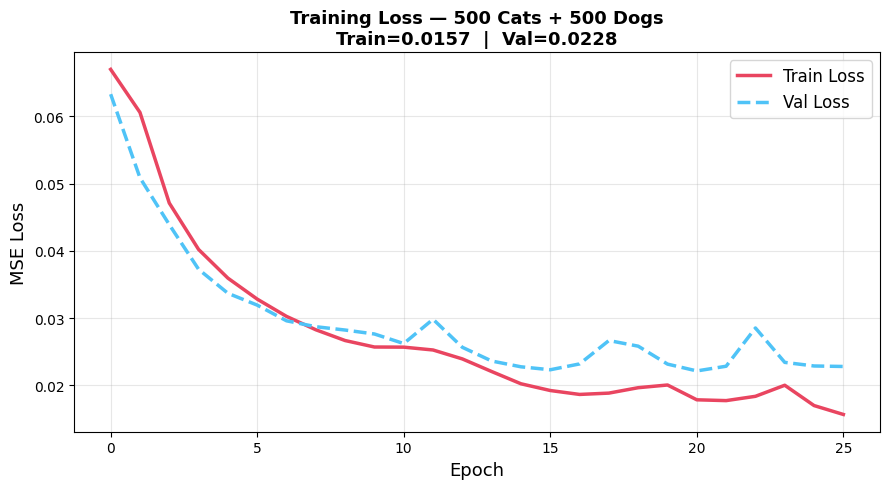

Saved: training_loss.png


In [50]:
plt.figure(figsize=(9, 5))
plt.plot(history.history["loss"],
         label="Train Loss", color="#E94560", linewidth=2.5)
plt.plot(history.history["val_loss"],
         label="Val Loss",   color="#4FC3F7", linewidth=2.5,
         linestyle="--")
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("MSE Loss", fontsize=13)
plt.title(f"Training Loss — 500 Cats + 500 Dogs\n"
          f"Train={history.history['loss'][-1]:.4f}  |  "
          f"Val={history.history['val_loss'][-1]:.4f}",
          fontsize=13, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("training_loss.png", dpi=150)
plt.show()
print("Saved: training_loss.png")


**STEP 7 — IMAGE RECONSTRUCTIONS**

/tmp/ipython-input-590029910.py:33: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-590029910.py:34: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=150)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


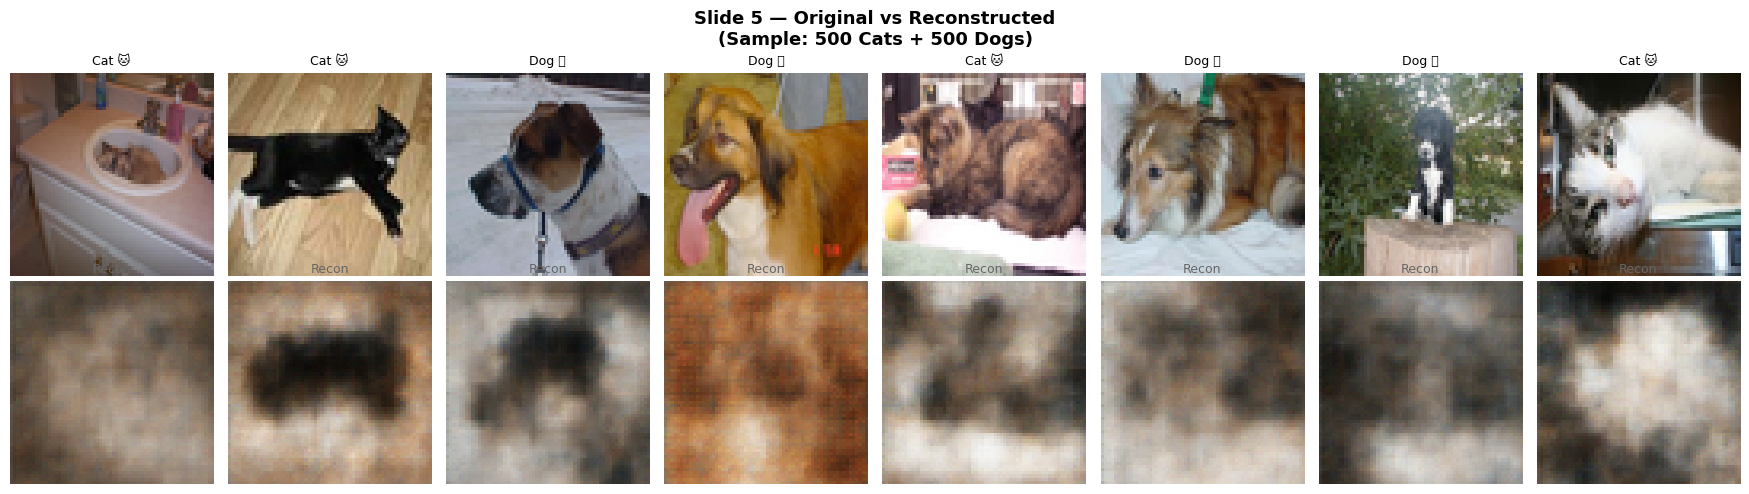

Saved: reconstructions.png


In [52]:
def visualize_reconstructions(autoencoder, X_val, y_val,
                               n=8, save_path="reconstructions.png"):
    # Pick n/2 cats and n/2 dogs for balanced display
    cat_idx  = np.where(y_val == 0)[0]
    dog_idx  = np.where(y_val == 1)[0]
    selected = np.concatenate([
        np.random.choice(cat_idx, n // 2, replace=False),
        np.random.choice(dog_idx, n // 2, replace=False)
    ])
    np.random.shuffle(selected)

    samples   = X_val[selected]
    lbl       = y_val[selected]
    recon     = autoencoder.predict(samples, verbose=0)
    label_map = {0: "Cat 🐱", 1: "Dog 🐶"}

    fig, axes = plt.subplots(2, n, figsize=(n * 2.2, 5))
    fig.suptitle("Slide 5 — Original vs Reconstructed\n"
                 "(Sample: 500 Cats + 500 Dogs)",
                 fontsize=13, fontweight="bold")

    for i in range(n):
        axes[0, i].imshow(np.clip(samples[i], 0, 1))
        axes[0, i].set_title(label_map[lbl[i]], fontsize=9)
        axes[0, i].axis("off")

        axes[1, i].imshow(np.clip(recon[i], 0, 1))
        axes[1, i].set_title("Recon", fontsize=9, color="#666")
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Original",     fontsize=11, labelpad=8)
    axes[1, 0].set_ylabel("Reconstructed", fontsize=11, labelpad=8)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Saved: {save_path}")

visualize_reconstructions(autoencoder, X_val, y_val)

**STEP 8 — LATENT SPACE EMBEDDING**


Encoding validation images → latent space...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Latent vectors: (200, 128)
PCA variance explained: 15.6% + 10.9%


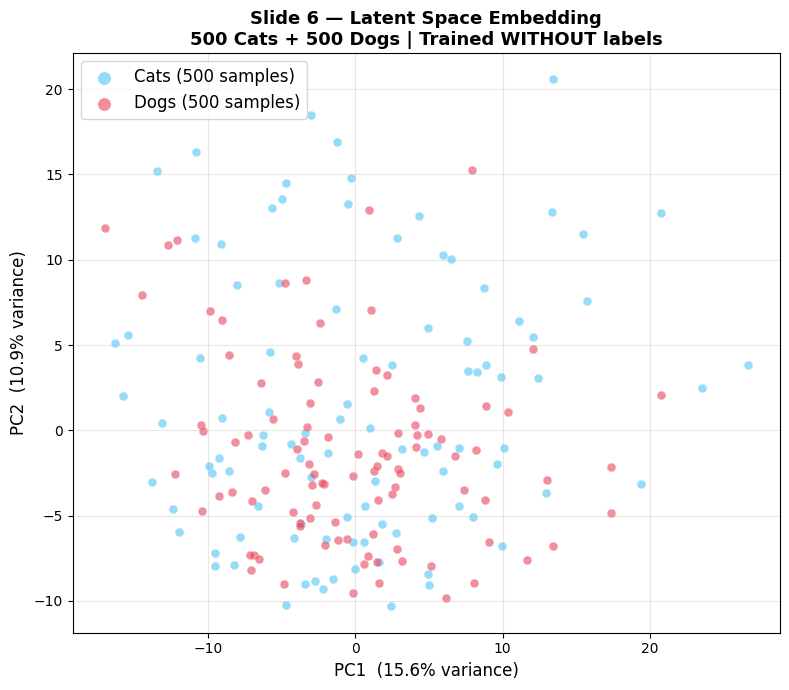

Saved: embedding_space.png


In [53]:
def visualize_embedding_space(encoder, X_val, y_val,
                               save_path="embedding_space.png"):
    print("\nEncoding validation images → latent space...")
    latent_vecs = encoder.predict(X_val, batch_size=BATCH_SIZE, verbose=1)
    print(f"Latent vectors: {latent_vecs.shape}")     # (200, 128)

    # PCA: 128 → 2 dims
    pca       = PCA(n_components=2, random_state=SEED)
    latent_2d = pca.fit_transform(latent_vecs)
    var       = pca.explained_variance_ratio_
    print(f"PCA variance explained: {var[0]*100:.1f}% + {var[1]*100:.1f}%")

    fig, ax = plt.subplots(figsize=(8, 7))
    class_info = {
        0: ("#4FC3F7", "Cats (500 samples)"),
        1: ("#E94560", "Dogs (500 samples)")
    }
    for label, (color, name) in class_info.items():
        mask = y_val == label
        ax.scatter(latent_2d[mask, 0], latent_2d[mask, 1],
                   c=color, label=name, alpha=0.6,
                   s=40, edgecolors="white", linewidths=0.3)

    ax.set_xlabel(f"PC1  ({var[0]*100:.1f}% variance)", fontsize=12)
    ax.set_ylabel(f"PC2  ({var[1]*100:.1f}% variance)", fontsize=12)
    ax.set_title("Slide 6 — Latent Space Embedding\n"
                 "500 Cats + 500 Dogs | Trained WITHOUT labels",
                 fontsize=13, fontweight="bold")
    ax.legend(fontsize=12, markerscale=1.5)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Saved: {save_path}")

visualize_embedding_space(encoder, X_val, y_val)


**STEP 9 — RECONSTRUCTION ERROR**


  Reconstruction Error per Class
  Cat MSE — Mean: 0.02328  Std: 0.00977
  Dog MSE — Mean: 0.02101  Std: 0.00862


/tmp/ipython-input-1240045442.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cat_errors, dog_errors], labels=["Cats", "Dogs"])


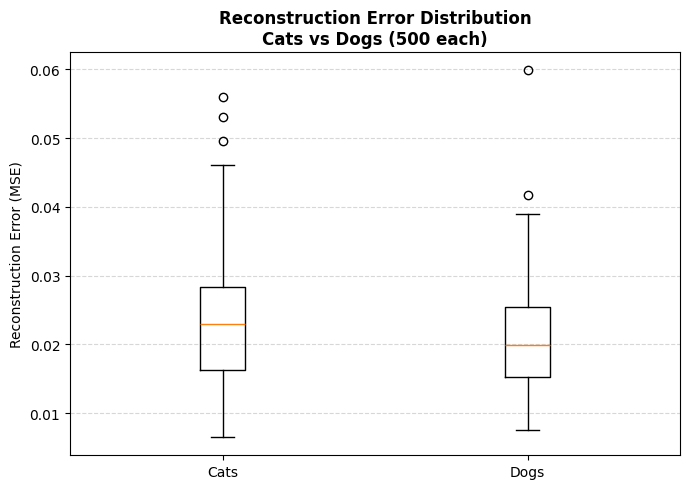

Saved: recon_error.png


In [54]:
def reconstruction_error_analysis(autoencoder, X_val, y_val,
                                   save_path="recon_error.png"):
    recon      = autoencoder.predict(X_val, verbose=0)
    errors     = np.mean(np.power(X_val - recon, 2), axis=(1, 2, 3))
    cat_errors = errors[y_val == 0]
    dog_errors = errors[y_val == 1]

    print("\n" + "="*45)
    print("  Reconstruction Error per Class")
    print("="*45)
    print(f"  Cat MSE — Mean: {cat_errors.mean():.5f}  "
          f"Std: {cat_errors.std():.5f}")
    print(f"  Dog MSE — Mean: {dog_errors.mean():.5f}  "
          f"Std: {dog_errors.std():.5f}")
    print("="*45)

    # Boxplot (same style as professor's fraud detection class)
    plt.figure(figsize=(7, 5))
    plt.boxplot([cat_errors, dog_errors], labels=["Cats", "Dogs"])
    plt.title("Reconstruction Error Distribution\n"
              "Cats vs Dogs (500 each)", fontweight="bold")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Saved: {save_path}")

reconstruction_error_analysis(autoencoder, X_val, y_val)


**SAVE MODELS**

In [55]:
autoencoder.save("autoencoder_1000.keras")
encoder.save("encoder_1000.keras")
decoder.save("decoder_1000.keras")

print("\n" + "="*55)
print("  ALL DONE — Output files:")
print("  sample_grid.png        → 1000 random sample preview")
print("  training_loss.png      → Train vs Val MSE curves")
print("  reconstructions.png    → Original vs Reconstructed")
print("  embedding_space.png    → Latent space scatter plot")
print("  recon_error.png        → Boxplot Cat vs Dog error")
print("  autoencoder_1000.keras → Saved full model")
print("="*55)


  ALL DONE — Output files:
  sample_grid.png        → 1000 random sample preview
  training_loss.png      → Train vs Val MSE curves
  reconstructions.png    → Original vs Reconstructed
  embedding_space.png    → Latent space scatter plot
  recon_error.png        → Boxplot Cat vs Dog error
  autoencoder_1000.keras → Saved full model
